In [ ]:
import pandas as pd 
import numpy as np
import cv2

In [ ]:
df=pd.read_csv("English_train.csv")

In [ ]:
#!/usr/bin/env python
# coding: utf-8

# In[ ]:


import tensorflow as tf
from tensorflow.python.keras import backend as K

logger = tf.get_logger()

class AttentionLayer(tf.keras.layers.Layer):
    """
    This class implements Bahdanau attention (https://arxiv.org/pdf/1409.0473.pdf).
    There are three sets of weights introduced W_a, U_a, and V_a
     """

    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        assert isinstance(input_shape, list)
        # Create a trainable weight variable for this layer.

        self.W_a = self.add_weight(name='W_a',
                                   shape=tf.TensorShape((input_shape[0][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.U_a = self.add_weight(name='U_a',
                                   shape=tf.TensorShape((input_shape[1][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.V_a = self.add_weight(name='V_a',
                                   shape=tf.TensorShape((input_shape[0][2], 1)),
                                   initializer='uniform',
                                   trainable=True)

        super(AttentionLayer, self).build(input_shape)  # Be sure to call this at the end

    def call(self, inputs):
        """
        inputs: [encoder_output_sequence, decoder_output_sequence]
        """
        assert type(inputs) == list
        encoder_out_seq, decoder_out_seq = inputs

        logger.debug(f"encoder_out_seq.shape = {encoder_out_seq.shape}")
        logger.debug(f"decoder_out_seq.shape = {decoder_out_seq.shape}")

        def energy_step(inputs, states):
            """ Step function for computing energy for a single decoder state
            inputs: (batchsize * 1 * de_in_dim)
            states: (batchsize * 1 * de_latent_dim)
            """

            logger.debug("Running energy computation step")

            if not isinstance(states, (list, tuple)):
                raise TypeError(f"States must be an iterable. Got {states} of type {type(states)}")

            encoder_full_seq = states[-1]

            """ Computing S.Wa where S=[s0, s1, ..., si]"""
            # <= batch size * en_seq_len * latent_dim
            W_a_dot_s = K.dot(encoder_full_seq, self.W_a)

            """ Computing hj.Ua """
            U_a_dot_h = K.expand_dims(K.dot(inputs, self.U_a), 1)  # <= batch_size, 1, latent_dim

            logger.debug(f"U_a_dot_h.shape = {U_a_dot_h.shape}")

            """ tanh(S.Wa + hj.Ua) """
            # <= batch_size*en_seq_len, latent_dim
            Ws_plus_Uh = K.tanh(W_a_dot_s + U_a_dot_h)

            logger.debug(f"Ws_plus_Uh.shape = {Ws_plus_Uh.shape}")

            """ softmax(va.tanh(S.Wa + hj.Ua)) """
            # <= batch_size, en_seq_len
            e_i = K.squeeze(K.dot(Ws_plus_Uh, self.V_a), axis=-1)
            # <= batch_size, en_seq_len
            e_i = K.softmax(e_i)

            logger.debug(f"ei.shape = {e_i.shape}")

            return e_i, [e_i]

        def context_step(inputs, states):
            """ Step function for computing ci using ei """

            logger.debug("Running attention vector computation step")

            if not isinstance(states, (list, tuple)):
                raise TypeError(f"States must be an iterable. Got {states} of type {type(states)}")

            encoder_full_seq = states[-1]

            # <= batch_size, hidden_size
            c_i = K.sum(encoder_full_seq * K.expand_dims(inputs, -1), axis=1)

            logger.debug(f"ci.shape = {c_i.shape}")

            return c_i, [c_i]

        # we don't maintain states between steps when computing attention
        # attention is stateless, so we're passing a fake state for RNN step function
        fake_state_c = K.sum(encoder_out_seq, axis=1)
        fake_state_e = K.sum(encoder_out_seq, axis=2)  # <= (batch_size, enc_seq_len, latent_dim

        """ Computing energy outputs """
        # e_outputs => (batch_size, de_seq_len, en_seq_len)
        last_out, e_outputs, _ = K.rnn(
            energy_step, decoder_out_seq, [fake_state_e], constants=[encoder_out_seq]
        )

        """ Computing context vectors """
        last_out, c_outputs, _ = K.rnn(
            context_step, e_outputs, [fake_state_c], constants=[encoder_out_seq]
        )

        return c_outputs, e_outputs

    def compute_output_shape(self, input_shape):
        """ Outputs produced by the layer """
        return [
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[1][2])),
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[0][1]))
        ]



In [ ]:
df.shape

(12565, 5)

In [ ]:
df.head()

,id,Link,Heading,Summary,Article
0,3938f547c863630032649c54e611e6b0,https://www.indiatvnews.com/news/world/russia-...,"Russia Ukraine War: Mastercard, Visa suspend o...","Since the invasion of Ukraine, the value of th...",Logos for MasterCard and Visa credit cards at ...
1,1b336d62e9502c5b91b7afd3c7bcff46,https://www.indiatvnews.com/news/world-author-...,Author-Diplomat Vikas Swarup moved to Delhi as...,India on Wednesday banned the pro-Khalistan Si...,Author-Diplomat Vikas Swarup moved to Delhi as...
2,082262f1c5a9e1112c39369403ff4e9a,https://www.indiatvnews.com/news/world/fumio-k...,Japan’s ex-top diplomat Fumio Kishida to becom...,Kishida replaces outgoing party leader Prime M...,Japan’s ex-top diplomat Fumio Kishida to becom...
3,82cce3b894007faf93e567d751dd2aef,https://www.indiatvnews.com/news/world/pakista...,Pakistan Sikhs urge India to facilitate access...,Pakistan Sikh Council (PSC) Patron-in-Chief Sa...,The Sikh community of Pakistan has urged India...
4,4b3bbf58136527fff41adc6c2f37d73d,https://www.indiatvnews.com/news/world/london-...,London knife attack suspect was jailed for 6 y...,"The Police said the attacker, Usman Khan, was ...",Armed police at the scene of an incident on Lo...


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12565 entries, 0 to 12564
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       12565 non-null  object
 1   Link     12565 non-null  object
 2   Heading  12565 non-null  object
 3   Summary  12565 non-null  object
 4   Article  12565 non-null  object
dtypes: object(5)
memory usage: 490.9+ KB


In [ ]:
df.describe()

,id,Link,Heading,Summary,Article
count,12565,12565,12565,12565,12565
unique,12565,12565,12565,12450,12549
top,3938f547c863630032649c54e611e6b0,https://www.indiatvnews.com/news/world/russia-...,"Russia Ukraine War: Mastercard, Visa suspend o...","Get all the latest news on coronavirus cases, ...",Representational Image
freq,1,1,1,46,10


In [ ]:
df.isnull().sum()

id         0
Link       0
Heading    0
Summary    0
Article    0
dtype: int64

In [ ]:
# dropping duplicate and null rows
df.drop_duplicates(subset=['Article'],inplace=True)

In [ ]:
df.shape

(12549, 5)

In [ ]:
df.dropna(axis=0,inplace=True)

In [ ]:
df.shape

(12549, 5)

In [ ]:
df.isnull().sum()

id         0
Link       0
Heading    0
Summary    0
Article    0
dtype: int64

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12549 entries, 0 to 12564
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       12549 non-null  object
 1   Link     12549 non-null  object
 2   Heading  12549 non-null  object
 3   Summary  12549 non-null  object
 4   Article  12549 non-null  object
dtypes: object(5)
memory usage: 588.2+ KB


Text Cleaning

In [ ]:
# source- github
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",

                           "didn't": "did not", "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",

                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",

                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",

                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",

                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",

                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",

                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",

                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",

                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",

                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",

                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",

                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",

                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",

                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",

                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",

                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",

                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",

                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",

                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",

                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",

                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",

                           "you're": "you are", "you've": "you have"}

In [ ]:
df['Article'][:10]

0    Logos for MasterCard and Visa credit cards at ...
1    Author-Diplomat Vikas Swarup moved to Delhi as...
2    Japan’s ex-top diplomat Fumio Kishida to becom...
3    The Sikh community of Pakistan has urged India...
4    Armed police at the scene of an incident on Lo...
5    He is a busy man: Pakistan PM Imran Khan takes...
6    More contagious virus variant found along New ...
7    US officials say President Donald Trump will r...
8    Kim Yo Jong rose to international prominence a...
9    The meeting is likely to review the progress m...
Name: Article, dtype: object

In [ ]:
import re           
from bs4 import BeautifulSoup 
from nltk.corpus import stopwords

In [ ]:
import nltk

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
stop_words = set(stopwords.words('english')) 

def text_cleaner(text,num):
    newString = text.lower()
    newString = BeautifulSoup(newString, "lxml").text
    newString = re.sub(r'\([^)]*\)', '', newString)
    newString = re.sub('"','', newString)
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])    
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString) 
    newString = re.sub('[m]{2,}', 'mm', newString)
    if(num==0):
        tokens = [w for w in newString.split() if not w in stop_words]
    else:
        tokens=newString.split()
    long_words=[]
    for i in tokens:
        if len(i)>1:                                                 #removing short word
            long_words.append(i)   
    return (" ".join(long_words)).strip()

In [ ]:
cleaned_article = []
for t in df['Article']:
  cleaned_article.append(text_cleaner(t,0))
cleaned_summary = []
for t in df['Summary']:
  cleaned_summary.append(text_cleaner(t,1))

In [ ]:
cleaned_article[:10]

['logos mastercard visa credit cards entrance new york coffee shopin latest blow russia financial system invasion ukraine mastercard visa said suspending operations country mastercard said cards issued russian banks longer supported network mastercard issued outside country work russian stores atms take decision lightly mastercard said statement adding made move discussions customers partners governments visa said working clients partners russia cease visa transactions coming days compelled act following russia unprovoked invasion ukraine unacceptable events witnessed visa chairman chief executive officer al kelly said statement twin suspensions announced within minutes followed private video call earlier day president volodymyr zelenskyy ukraine us lawmakers conversation zelenskyy asked us turn mastercard visa russia rep brad sherman democrat california tweeted agree added mastercard visa made announcements earlier week visa mastercard announced limited moves block financial instituti

In [ ]:
# import spacy
# nlp = spacy.load('en_core_web_sm', disable=['ner', 'parser'])
# text = [str(doc) for doc in nlp.pipe(cleaned_article, batch_size=100)]

In [ ]:
# text[:10]

In [ ]:
# summary = ['_START_ '+ str(doc) + ' _END_' for doc in nlp.pipe(cleaned_summary, batch_size=50,)]

In [ ]:
# summary

In [ ]:
import numpy as np

In [ ]:
df['cleaned_article']=cleaned_article
df['cleaned_summary']=cleaned_summary
df['cleaned_article'].replace('', np.nan, inplace=True)
df.dropna(axis=0,inplace=True)

In [ ]:
for i in range(5):
    print("Article:",df['cleaned_article'][i])
    print("Summary:",df['cleaned_summary'][i])
    print("\n")

Article: logos mastercard visa credit cards entrance new york coffee shopin latest blow russia financial system invasion ukraine mastercard visa said suspending operations country mastercard said cards issued russian banks longer supported network mastercard issued outside country work russian stores atms take decision lightly mastercard said statement adding made move discussions customers partners governments visa said working clients partners russia cease visa transactions coming days compelled act following russia unprovoked invasion ukraine unacceptable events witnessed visa chairman chief executive officer al kelly said statement twin suspensions announced within minutes followed private video call earlier day president volodymyr zelenskyy ukraine us lawmakers conversation zelenskyy asked us turn mastercard visa russia rep brad sherman democrat california tweeted agree added mastercard visa made announcements earlier week visa mastercard announced limited moves block financial in

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
df

,id,Link,Heading,Summary,Article,cleaned_article,cleaned_summary
0,3938f547c863630032649c54e611e6b0,https://www.indiatvnews.com/news/world/russia-...,"Russia Ukraine War: Mastercard, Visa suspend o...","Since the invasion of Ukraine, the value of th...",Logos for MasterCard and Visa credit cards at ...,logos mastercard visa credit cards entrance ne...,since the invasion of ukraine the value of the...
1,1b336d62e9502c5b91b7afd3c7bcff46,https://www.indiatvnews.com/news/world-author-...,Author-Diplomat Vikas Swarup moved to Delhi as...,India on Wednesday banned the pro-Khalistan Si...,Author-Diplomat Vikas Swarup moved to Delhi as...,author diplomat vikas swarup moved delhi indo ...,india on wednesday banned the pro khalistan si...
2,082262f1c5a9e1112c39369403ff4e9a,https://www.indiatvnews.com/news/world/fumio-k...,Japan’s ex-top diplomat Fumio Kishida to becom...,Kishida replaces outgoing party leader Prime M...,Japan’s ex-top diplomat Fumio Kishida to becom...,japan ex top diplomat fumio kishida become new...,kishida replaces outgoing party leader prime m...
3,82cce3b894007faf93e567d751dd2aef,https://www.indiatvnews.com/news/world/pakista...,Pakistan Sikhs urge India to facilitate access...,Pakistan Sikh Council (PSC) Patron-in-Chief Sa...,The Sikh community of Pakistan has urged India...,sikh community pakistan urged india facilitate...,pakistan sikh council patron in chief sardar r...
4,4b3bbf58136527fff41adc6c2f37d73d,https://www.indiatvnews.com/news/world/london-...,London knife attack suspect was jailed for 6 y...,"The Police said the attacker, Usman Khan, was ...",Armed police at the scene of an incident on Lo...,armed police scene incident london bridge cent...,the police said the attacker usman khan was co...
...,...,...,...,...,...,...,...
12560,1f4dc11a672137f6f6cc33c9c1644040,https://www.indiatvnews.com/news/world-china-a...,China announces tariff hike on $75 billion of ...,Tariffs of 10 per cent and 5 per cent will tak...,China announces tariff hike on $75 billion of ...,china announces tariff hike billion us product...,tariffs of per cent and per cent will take eff...
12561,963b9f0a8d88948857626afb9f185d2c,https://www.indiatvnews.com/news/world-iran-sa...,Iran says ‘idiotic’ new US sanctions shut door...,Iran warned Tuesday that new U.S. sanctions ta...,Iran says ‘idiotic’ new US sanctions shut door...,iran says idiotic new us sanctions shut doors ...,iran warned tuesday that new sanctions targeti...
12562,0c52632fe53e8671377c4873f64c2957,https://www.indiatvnews.com/news/world/coronav...,Chinese COVID-19 vaccine BBIBP-CorV shows prom...,A previous clinical trial reported similar res...,Chinese COVID-19 vaccine BBIBP-CorV shows prom...,chinese covid vaccine bbibp corv shows promise...,previous clinical trial reported similar resul...
12563,bee435262d4db4c94bf3cb5976bd7e15,https://www.indiatvnews.com/news/world/russia-...,"Ukrainian women including MPs, Miss Universe p...",Former Miss Universe Anastasiia Lenna also sha...,"Miss Universe Anastasiia Lenna (L), Ukranian M...",miss universe anastasiia lenna ukranian mp kir...,former miss universe anastasiia lenna also sha...


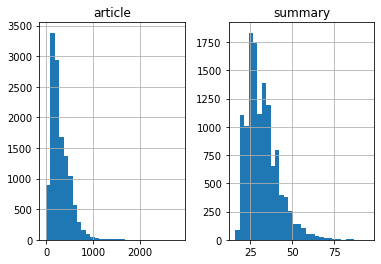

In [ ]:
article_word_count = []
summary_word_count = []

for i in df['cleaned_article']:
      article_word_count.append(len(i.split()))

for i in df['cleaned_summary']:
      summary_word_count.append(len(i.split()))

length_df = pd.DataFrame({'article':article_word_count, 'summary':summary_word_count})
length_df.hist(bins = 30)
plt.show()

In [ ]:
cnt=0
for i in df['cleaned_summary']:
    if(len(i.split())<=30):
        cnt=cnt+1
print(cnt/len(df['cleaned_summary']))

cnt=0
for i in df['cleaned_article']:
    if(len(i.split())<=250):
        cnt=cnt+1
print(cnt/len(df['cleaned_article']))

0.5080490914886835
0.509802358941664


In [ ]:
max_len_article=250
max_len_summary=30

In [ ]:
cleaned_article =np.array(df['cleaned_article'])
cleaned_summary=np.array(df['cleaned_summary'])

short_article=[]
short_summary=[]

for i in range(len(cleaned_article)):
    if(len(cleaned_article[i].split())<=max_len_article and len(cleaned_summary[i].split())<=max_len_summary):
        short_article.append(cleaned_article[i])
        short_summary.append(cleaned_summary[i])
        
df1=pd.DataFrame({'article':short_article,'summary':short_summary})

In [ ]:
df1.shape

(3647, 2)

In [ ]:
df1['summary'] = df1['summary'].apply(lambda x : 'starat '+ x + ' enad')

In [ ]:
df1

,article,summary
0,contagious virus variant found along new york ...,starat the long island man had first tested po...
1,us officials say president donald trump recogn...,starat the officials say recognition of jerusa...
2,china monday successfully launched new civilia...,starat they were launched on long march carrie...
3,north korean leader kim jong un secret trip ch...,starat however there is no official confirmati...
4,external affairs minister sushma swarajan indi...,starat four members of sikh family including t...
...,...,...
3642,national intelligence service south korea thur...,starat nato secretary general jens stoltenberg...
3643,donald trump tariff china christmas economy el...,starat us president donald trump has said that...
3644,us president donald trump wednesday signed bil...,starat us president donald trump on wednesday ...
3645,pakistan fm shah mehmood qureshi recovers covi...,starat pakistan foreign minister shah mehmood ...


Building Tokenizer

In [ ]:
from sklearn.model_selection import train_test_split
x_tr,x_val,y_tr,y_val=train_test_split(np.array(df1['article']),np.array(df1['summary']),test_size=0.1,random_state=0,shuffle=True) 

In [ ]:
! pip install keras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences

In [ ]:
x_tokenizer = Tokenizer() 
x_tokenizer.fit_on_texts(list(x_tr))

In [ ]:
x_tokenizer.word_counts

OrderedDict([('police', 1236),
             ('officer', 163),
             ('injured', 509),
             ('us', 3568),
             ('capitol', 45),
             ('riot', 7),
             ('dies', 20),
             ('toll', 304),
             ('rises', 28),
             ('fivea', 1),
             ('sustained', 31),
             ('injuries', 120),
             ('violence', 252),
             ('died', 283),
             ('officials', 699),
             ('said', 8802),
             ('raising', 56),
             ('death', 580),
             ('five', 433),
             ('brian', 9),
             ('sicknick', 2),
             ('engaging', 15),
             ('protesters', 63),
             ('wednesday', 552),
             ('returned', 71),
             ('division', 33),
             ('office', 481),
             ('collapsed', 53),
             ('taken', 354),
             ('local', 406),
             ('hospital', 364),
             ('passed', 95),
             ('away', 172),
             ('d

In [ ]:
thresh=4

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for k,v in x_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+v
    if(v<thresh):
        cnt=cnt+1
        freq=freq+v
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 62.968422431865825
Total Coverage of rare words: 5.497579090866356


In [ ]:
x_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
x_tokenizer.fit_on_texts(list(x_tr))

x_tr_seq    =   x_tokenizer.texts_to_sequences(x_tr) 
x_val_seq   =   x_tokenizer.texts_to_sequences(x_val)

x_tr    =   pad_sequences(x_tr_seq,  maxlen=max_len_article, padding='post')
x_val   =   pad_sequences(x_val_seq, maxlen=max_len_article, padding='post')

x_voc   =  x_tokenizer.num_words + 1

In [ ]:
x_voc

11306

In [ ]:
y_tokenizer = Tokenizer()   
y_tokenizer.fit_on_texts(list(y_tr))

In [ ]:
thresh=6

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for k,v in y_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+v
    if(v<thresh):
        cnt=cnt+1
        freq=freq+v
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 81.69315403422983
Total Coverage of rare words: 15.430745641433358


In [ ]:
y_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
y_tokenizer.fit_on_texts(list(y_tr))

y_tr_seq    =   y_tokenizer.texts_to_sequences(y_tr) 
y_val_seq   =   y_tokenizer.texts_to_sequences(y_val) 

y_tr    =   pad_sequences(y_tr_seq, maxlen=max_len_summary, padding='post')
y_val   =   pad_sequences(y_val_seq, maxlen=max_len_summary, padding='post')

y_voc  =   y_tokenizer.num_words +1

In [ ]:
y_voc

1798

In [ ]:
y_tokenizer.word_counts['enad']

3282

In [ ]:
y_tokenizer.word_counts['starat'],len(y_tr)

(3282, 3282)

In [ ]:
ind=[]
for i in range(len(y_tr)):
    cnt=0
    for j in y_tr[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_tr=np.delete(y_tr,ind, axis=0)
x_tr=np.delete(x_tr,ind, axis=0)

In [ ]:
ind=[]
for i in range(len(y_val)):
    cnt=0
    for j in y_val[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_val=np.delete(y_val,ind, axis=0)
x_val=np.delete(x_val,ind, axis=0)

Model Building

In [ ]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
from keras import backend as K 
K.clear_session()

In [ ]:
# !pip install Attention

# !pip install keras-self-attention

In [ ]:
# !pip install AttentionLayer

In [ ]:
# !pip install keras-attention

In [ ]:
from attention import AttentionLayer

In [ ]:
latent_dim = 300
embedding_dim=100

# Encoder
encoder_inputs = Input(shape=(max_len_article,))

#embedding layer
enc_emb =  Embedding(x_voc, embedding_dim,trainable=True)(encoder_inputs)

#encoder lstm 1
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

#encoder lstm 2
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

#encoder lstm 3
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True,dropout=0.4,recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))

#embedding layer
dec_emb_layer = Embedding(y_voc, embedding_dim,trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True,dropout=0.4,recurrent_dropout=0.2)
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c])

# Attention layer
attn_layer = AttentionLayer(name='attention_layer')
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# Concat attention input and decoder LSTM output
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

#dense layer
decoder_dense =  TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_concat_input)

# Define the model 
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 250)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 250, 100)     1130600     ['input_1[0][0]']                
                                                                                                  
 lstm (LSTM)                    [(None, 250, 300),   481200      ['embedding[0][0]']              
                                 (None, 300),                                                     
                                 (None, 300)]                                                     
                                                                                              

In [ ]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=2)

In [ ]:
history=model.fit([x_tr,y_tr[:,:-1]], y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:] ,epochs=50,callbacks=[es],batch_size=256, validation_data=([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]))

Epoch 1/50
13/13 [==============================] - 477s 35s/step - loss: 5.4470 - val_loss: 4.4879
Epoch 2/50
13/13 [==============================] - 449s 34s/step - loss: 4.6449 - val_loss: 4.4006
Epoch 3/50
13/13 [==============================] - 455s 35s/step - loss: 4.5508 - val_loss: 4.3353
Epoch 4/50
13/13 [==============================] - 451s 35s/step - loss: 4.4728 - val_loss: 4.2853
Epoch 5/50
13/13 [==============================] - 444s 34s/step - loss: 4.4098 - val_loss: 4.2349
Epoch 6/50
13/13 [==============================] - 442s 34s/step - loss: 4.3572 - val_loss: 4.1863
Epoch 7/50
13/13 [==============================] - 450s 35s/step - loss: 4.2901 - val_loss: 4.2152
Epoch 8/50
13/13 [==============================] - 444s 34s/step - loss: 4.2535 - val_loss: 4.0800
Epoch 9/50
13/13 [==============================] - 437s 34s/step - loss: 4.1973 - val_loss: 4.0577
Epoch 10/50
13/13 [==============================] - 453s 35s/step - loss: 4.1492 - val_loss: 3.9838

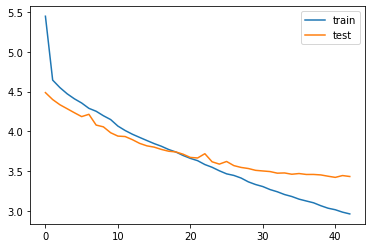

In [ ]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [ ]:
reverse_target_word_index=y_tokenizer.index_word
reverse_source_word_index=x_tokenizer.index_word
target_word_index=y_tokenizer.word_index

In [ ]:
# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_len_article,latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs) 
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#attention inference
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_inf_concat) 

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [ ]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    
    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['starat']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
      
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])

        sampled_token = reverse_target_word_index[sampled_token_index]
        
        if(sampled_token!='enad'):
            decoded_sentence += ' '+sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'enad'  or len(decoded_sentence.split()) >= (max_len_summary-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

In [ ]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['starat']) and i!=target_word_index['enad']):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString

In [ ]:
for i in range(0,100):
    print("Article:",seq2text(x_tr[i]))
    print("Original summary:",seq2summary(y_tr[i]))
    print("Predicted summary:",decode_sequence(x_tr[i].reshape(1,max_len_article)))
    print("\n")

Article: police officer injured us capitol riot dies toll rises police officer sustained injuries us capitol violence died officials said raising death toll riot five us capitol police officer brian injured engaging protesters wednesday returned division office collapsed taken local hospital passed away due injuries sustained duty approximately pm evening us capitol police said late night statement thursday death investigated metropolitan police department homicide branch federal agencies statement said congressman dean phillips said heart goes family officer risk lives every day protect serve communities dignity principle us capitol police officer died yesterday riot makes five known deaths trump must accountability congressman lloyd tweeted thursday others died include us air force veteran trump supporter resident san diego shot capitol police wednesday three died medical emergencies according officials capitol police officers injured thousands president donald trump supporters storm